<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 10px 20px rgba(0,0,0,0.19), 0 6px 6px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 800; font-size: 2.5em; color: white; text-shadow: 2px 2px 4px #000;">✨ IMPORTS ✨</span>
</div>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score
import pickle
from collections import defaultdict
from sklearn.utils import shuffle
import os
import cv2
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd

from torchinfo import summary
from sklearn.metrics import confusion_matrix
import seaborn as sns



<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 10px 20px rgba(0,0,0,0.19), 0 6px 6px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 800; font-size: 2.5em; color: white; text-shadow: 2px 2px 4px #000;">✨ LOADING THE SPLIT DATA ARRAYS ✨</span>
</div>

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">📁 reminder to change the folder path to your numpy array folder 📁</span>
</div>

In [2]:
import numpy as np
import os

# Define the folder path
folder_path = r"D:\PYTHONIG\newwindow\NOTEBOOKS_2025\aprilmay2025\data\numpy\cwtnormalized\concatenatedspectrograms"

# Load the numpy files into the respective arrays with the correct capitalized naming
eeg_fold_1 = np.load(os.path.join(folder_path, 'CWT_DATA_FOLD_fold_1.npy'))
labels_fold_1 = np.load(os.path.join(folder_path, 'CWT_LABELS_FOLD_fold_1.npy'))
patients_fold_1 = np.load(os.path.join(folder_path, 'CWT_PATIENTS_FOLD_fold_1.npy'))

eeg_fold_2 = np.load(os.path.join(folder_path, 'CWT_DATA_FOLD_fold_2.npy'))
labels_fold_2 = np.load(os.path.join(folder_path, 'CWT_LABELS_FOLD_fold_2.npy'))
patients_fold_2 = np.load(os.path.join(folder_path, 'CWT_PATIENTS_FOLD_fold_2.npy'))

eeg_fold_3 = np.load(os.path.join(folder_path, 'CWT_DATA_FOLD_fold_3.npy'))
labels_fold_3 = np.load(os.path.join(folder_path, 'CWT_LABELS_FOLD_fold_3.npy'))
patients_fold_3 = np.load(os.path.join(folder_path, 'CWT_PATIENTS_FOLD_fold_3.npy'))

eeg_fold_4 = np.load(os.path.join(folder_path, 'CWT_DATA_FOLD_fold_4.npy'))
labels_fold_4 = np.load(os.path.join(folder_path, 'CWT_LABELS_FOLD_fold_4.npy'))
patients_fold_4 = np.load(os.path.join(folder_path, 'CWT_PATIENTS_FOLD_fold_4.npy'))

eeg_fold_5 = np.load(os.path.join(folder_path, 'CWT_DATA_FOLD_fold_5.npy'))
labels_fold_5 = np.load(os.path.join(folder_path, 'CWT_LABELS_FOLD_fold_5.npy'))
patients_fold_5 = np.load(os.path.join(folder_path, 'CWT_PATIENTS_FOLD_fold_5.npy'))

eeg_folds = [eeg_fold_1, eeg_fold_2, eeg_fold_3, eeg_fold_4, eeg_fold_5]
labels_folds = [labels_fold_1, labels_fold_2, labels_fold_3, labels_fold_4, labels_fold_5]
patients_folds = [patients_fold_1, patients_fold_2, patients_fold_3, patients_fold_4, patients_fold_5]

for i in range(len(eeg_folds)):
    eeg_folds[i] = eeg_folds[i].astype(np.float16)

In [3]:
eeg_fold_1.shape

(1095, 224, 224, 3)

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">data balancer & early stopping</span>
</div>

In [4]:
def data_balancer(data, labels, factor):
    # Count the number of samples in each class
    num_class_0 = np.sum(labels == 0)
    num_class_1 = np.sum(labels == 1)
    num_class_2 = np.sum(labels == 2)

    # Find the minimum number of samples across all classes
    min_samples = min(num_class_0, num_class_1, num_class_2)

    # Calculate the number of samples to take from each class
    samples_per_class = min_samples // factor

    # Randomly sample 'samples_per_class' from each class
    class_0_indices = np.random.choice(np.where(labels == 0)[0], samples_per_class, replace=False)
    class_1_indices = np.random.choice(np.where(labels == 1)[0], samples_per_class, replace=False)
    class_2_indices = np.random.choice(np.where(labels == 2)[0], samples_per_class, replace=False)

    # Combine balanced indices
    balanced_indices = np.concatenate((class_0_indices, class_1_indices, class_2_indices))

    # Shuffle the balanced indices
    np.random.shuffle(balanced_indices)

    # Create balanced training data and labels
    balanced_data = data[balanced_indices]
    balanced_labels = labels[balanced_indices]

    return balanced_data, balanced_labels

In [5]:
class EarlyStopping:
    def __init__(self, patience=5):
        """
        Initializes the early stopping mechanism based on divergence detection.

        Args:
            patience (int): Number of consecutive epochs with increasing validation loss
                            before stopping.
        """
        self.patience = patience
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        """
        Checks if the validation loss is diverging and updates the state accordingly.

        Args:
            val_loss (float): Current epoch's validation loss.
            model (torch.nn.Module): The model being trained.
        """
        if self.best_loss is None or val_loss < self.best_loss:
            # Improvement detected
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0
        else:
            # Validation loss increased
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Divergence detected. Stopping training after {self.counter} epochs.")
                self.early_stop = True

    def load_best_model(self, model):
        """
        Restores the model to the state with the lowest validation loss.

        Args:
            model (torch.nn.Module): The model to restore.
        """
        model.load_state_dict(self.best_model_state)




<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">Result plotting</span>
</div>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    auc,
    f1_score,
    balanced_accuracy_score,
    classification_report,
)
from sklearn.preprocessing import label_binarize

def plot_metrics(labels, predictions, n_classes=3):
    """
    Plots and computes metrics for classification tasks.

    Args:
        labels (array-like): True labels.
        predictions (array-like): Predicted probabilities or class predictions.
        n_classes (int): Number of classes (default is 3 for multi-class classification).
    """
    # If predictions are probabilities, convert to class predictions
    if predictions.ndim > 1:
        predicted_classes = np.argmax(predictions, axis=1)
    else:
        predicted_classes = predictions

    # Confusion Matrix
    cm = confusion_matrix(labels, predicted_classes)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Class-wise Accuracy
    print("\nClass-wise Accuracy:")
    for d in range(n_classes):
        correct_preds = cm[d][d]
        total_true_samples = sum(cm[d])
        ratio_correct = correct_preds / total_true_samples if total_true_samples != 0 else 0
        print(f'Class {d}: Correct Predictions / Total True Samples = {correct_preds}/{total_true_samples} ({ratio_correct:.2%})')

    # Precision-Recall Curves and AUPRC
    print("\nPrecision-Recall Curves:")
    labels_binarized = label_binarize(labels, classes=np.arange(n_classes))
    auprcs = []
    for class_idx in range(n_classes):
        precision, recall, _ = precision_recall_curve(labels_binarized[:, class_idx], predictions[:, class_idx])
        auprc = auc(recall, precision)
        auprcs.append(auprc)
        plt.plot(recall, precision, label=f'Class {class_idx + 1} (AUPRC = {auprc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves for each class')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # ROC Curves and AUC
    print("\nROC Curves:")
    for class_idx in range(n_classes):
        fpr, tpr, _ = roc_curve(labels_binarized[:, class_idx], predictions[:, class_idx])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_idx + 1} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for each class')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # Mean F1 Score
    f1 = f1_score(labels, predicted_classes, average='macro')
    print(f"\nMean F1 Score: {f1:.4f}")

    # Balanced Accuracy
    balanced_acc = balanced_accuracy_score(labels, predicted_classes)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    # Average AUPRC
    mean_auprc = np.mean(auprcs)
    print(f"Average AUPRC: {mean_auprc:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(labels, predicted_classes))

    return {
        "confusion_matrix": cm,
        "class_wise_accuracy": [cm[d][d] / sum(cm[d]) if sum(cm[d]) != 0 else 0 for d in range(n_classes)],
        "mean_f1_score": f1,
        "balanced_accuracy": balanced_acc,
        "average_auprc": mean_auprc,
        "auprc_per_class": auprcs,
    }

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(238, 206, 148),rgb(238, 150, 150)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">MODEL GOES HERE</span>
</div>

In [7]:
debug_mode_flag = False
import torch
import torch.nn as nn

class CustomCnn(nn.Module):
    def __init__(self, debug_mode_flag=False):
        super().__init__()
        self.debug_mode_flag = debug_mode_flag
        
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces spatial size
        )
        
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Further reduces spatial size
        )

        # Global Average Pooling to reduce spatial dimensions 
        self.global_avg_pool = nn.AdaptiveAvgPool2d((8, 8))  # Keeps a manageable seq_len
        self.flatten = nn.Flatten(start_dim=2)  # Keeps batch & channel dims

    def forward(self, x):
        if self.debug_mode_flag: print(f"Input shape: {x.shape}")
        
        x = self.block_1(x)
        if self.debug_mode_flag: print(f"Block 1 shape: {x.shape}")
        
        x = self.block_2(x)
        if self.debug_mode_flag: print(f"Block 2 shape: {x.shape}")
        
        x = self.global_avg_pool(x)  # (batch, 128, 8, 8)
        if self.debug_mode_flag: print(f"Global Avg Pool shape: {x.shape}")

        # x = self.flatten(x)  # (batch, 128, 64)
        # if self.debug_mode_flag: print(f"Flattened shape (Transformer Input): {x.shape}")
        
        return x

    
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.att = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x):
        attn_output, _ = self.att(x, x, x)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)
    
class TRANS_CNN(nn.Module):
    def __init__(self, input_shape, num_classes, embed_dim=512, num_heads=2, ff_dim=64, num_transformer_blocks=4):
        
        super(TRANS_CNN,self).__init__()
        
        self.num_transformer_blocks = num_transformer_blocks
        self.cnn_extractor = CustomCnn()
        
        self.projection = nn.Linear(512, embed_dim)
        
        self.encoder = nn.ModuleList([
            TransformerEncoder(embed_dim,num_heads,ff_dim) for _ in range(num_transformer_blocks)
        ])
        
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.1)
        
        self.precls = nn.Linear(embed_dim,embed_dim)
        self.precls2 = nn.Linear(embed_dim,embed_dim)
        self.precls3 = nn.Linear(embed_dim,embed_dim//4)
        
        self.clf = nn.Linear(embed_dim//4,num_classes)
        
        
    def forward(self,x):
        
        x = self.cnn_extractor(x)
        if debug_mode_flag: print(f"x shape after cnn extraction = {x.shape}")
        
        B,C,H,W = x.shape
        
        x = x.view(B,H*W,C)
        if debug_mode_flag: print(f"x shape after changing view= {x.shape}")
        
        # x = self.projection(x)
        # if debug_mode_flag: print(f"x shape after projection= {x.shape}")
        
        for encoderblock in self.encoder:
            x = encoderblock(x)
            
        if debug_mode_flag: print(f"x shape after passing thru encoder= {x.shape}")
        
        x = x.permute(1,0,2)
        if debug_mode_flag: print(f"x shape after permuting{x.shape}")
        
        x = self.precls3(x)
        if debug_mode_flag: print(f"precls3 {x.shape}")
        
        x = self.dropout(x)
        
        x = x.mean(dim=0)  # Global average pooling over sequence (9 tokens → 1 token)
        if debug_mode_flag: print(f"x shape after average pooling {x.shape}")

        x = self.clf(x)  #they see me rolling
        if debug_mode_flag: print(f"cls {x.shape}")
        
        
        return x

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(238, 206, 148),rgb(238, 150, 150)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">Test with demo data & model Summary</span>
</div>

In [8]:
model  = TRANS_CNN(input_shape=(224,224,3),num_classes=3,num_transformer_blocks=4,embed_dim=128) # declare model here
randomdata = torch.randn((1,3,224,224))
output = model(randomdata)
output.shape

torch.Size([1, 3])

In [9]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                       Param #
TRANS_CNN                                                    --
├─CustomCnn: 1-1                                             --
│    └─Sequential: 2-1                                       --
│    │    └─Conv2d: 3-1                                      448
│    │    └─BatchNorm2d: 3-2                                 32
│    │    └─ReLU: 3-3                                        --
│    │    └─Conv2d: 3-4                                      4,640
│    │    └─BatchNorm2d: 3-5                                 64
│    │    └─ReLU: 3-6                                        --
│    │    └─MaxPool2d: 3-7                                   --
│    └─Sequential: 2-2                                       --
│    │    └─Conv2d: 3-8                                      18,496
│    │    └─BatchNorm2d: 3-9                                 128
│    │    └─ReLU: 3-10                                       --
│    │    └─Conv2d: 3-11  

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(238, 206, 148),rgb(238, 150, 150)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">Training Code</span>
</div>

In [10]:

import pandas as pd
import os
import datetime


torch.random.manual_seed(42)  # For reproducibility
np.random.seed(42)  # For reproducibility

params = {'num_heads': 8, 'num_transformer_blocks': 8, 'learning_rate': 7.92e-05, 'optimizer': 'Adam', 'weight_decay': 3.62e-05, 'batch_size': 10, 'factor': 1}


# Fold indices and other configurations
num_folds = 5
fold_indices = np.random.permutation(np.arange(num_folds))
val_fold_indices = np.roll(fold_indices, 1)

test_folds_chosen = []
val_folds_chosen = []
fold_confusion_matrices = []  # To store confusion matrices for each fold
fold_accuracies = []  # To store balanced accuracy for each fold
fold_auprcs = []  # To store AUPRC for each fold

# Model and training configurations
num_classes = 3
epochs = 100
input_shape = (3,224,224)
embed_dim = 128
num_heads = params['num_heads']
num_transformer_blocks = params['num_transformer_blocks']
learning_rate = params['learning_rate']
optimizer = params['optimizer']
weight_decay = params['weight_decay']
batch_size = params['batch_size']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [11]:
def save_results_to_csv(fold_accuracies, fold_auprcs, fold_confusion_matrices, model_info, csv_path=r"D:\PYTHONIG\aprilmay2025\newnotebooks\results.csv"):
    """
    Save all results from the current experiment to a CSV file
    
    Parameters:
    - fold_accuracies: list of balanced accuracy scores for each fold
    - fold_auprcs: list of AUPRC scores for each fold
    - fold_confusion_matrices: list of confusion matrices for each fold
    - model_info: string with model architecture description
    - csv_path: path to the CSV file to save results
    """
    # Current time for experiment identification
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    
    # Prepare data for the DataFrame
    data = {
        "timestamp": timestamp,
        "model_info": model_info,
        "num_classes": num_classes,
        "learning_rate": learning_rate,
        "epochs": epochs,
        "mean_balanced_accuracy": np.mean(fold_accuracies),
        "std_balanced_accuracy": np.std(fold_accuracies),
        "mean_auprc": np.mean(fold_auprcs),
        "std_auprc": np.std(fold_auprcs),
    }
    
    # Add individual fold results
    for i, (acc, auprc) in enumerate(zip(fold_accuracies, fold_auprcs)):
        data[f"fold_{i+1}_accuracy"] = acc
        data[f"fold_{i+1}_auprc"] = auprc
    
    # Add confusion matrix info
    for i, cm in enumerate(fold_confusion_matrices):
        data[f"fold_{i+1}_confusion_matrix"] = str(cm)
    
    # Create DataFrame and append to CSV
    df = pd.DataFrame([data])
    
    # Check if file exists
    file_exists = os.path.isfile(csv_path)
    
    # Save to CSV
    if file_exists:
        df.to_csv(csv_path, mode='a', header=False, index=False)
    else:
        df.to_csv(csv_path, mode='w', header=True, index=False)
    
    print(f"Results saved to {csv_path}")

Fold No: 1
training on folds: [[np.int64(4), np.int64(2), np.int64(0)]]
validation on folds: 3
test on folds: 1
Epoch [1/100], Loss: 1.0888, Accuracy: 0.4287
Validation Loss: 0.9901, Validation Accuracy: 0.4124
Epoch [2/100], Loss: 1.0377, Accuracy: 0.5202
Validation Loss: 0.9623, Validation Accuracy: 0.4456
Epoch [3/100], Loss: 1.0219, Accuracy: 0.5443
Validation Loss: 0.9841, Validation Accuracy: 0.4763
Epoch [4/100], Loss: 0.9970, Accuracy: 0.5983
Validation Loss: 0.9810, Validation Accuracy: 0.5010
Epoch [5/100], Loss: 0.9814, Accuracy: 0.6272
Validation Loss: 1.0445, Validation Accuracy: 0.4904
Epoch [6/100], Loss: 0.9762, Accuracy: 0.6127
Validation Loss: 1.0741, Validation Accuracy: 0.4673
Epoch [7/100], Loss: 0.9560, Accuracy: 0.6580
Validation Loss: 1.0209, Validation Accuracy: 0.5004
Epoch [8/100], Loss: 0.9541, Accuracy: 0.6407
Validation Loss: 1.0658, Validation Accuracy: 0.4860
Epoch [9/100], Loss: 0.9500, Accuracy: 0.6455
Validation Loss: 0.9588, Validation Accuracy: 0.53

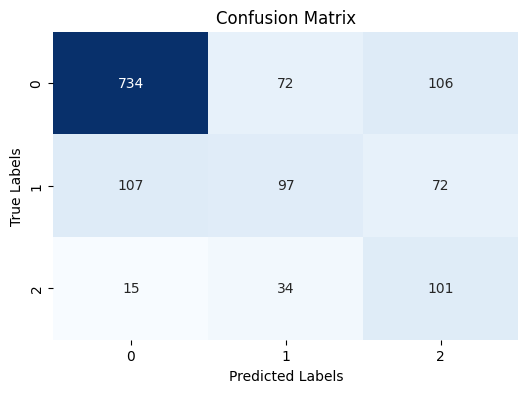


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 734/912 (80.48%)
Class 1: Correct Predictions / Total True Samples = 97/276 (35.14%)
Class 2: Correct Predictions / Total True Samples = 101/150 (67.33%)

Precision-Recall Curves:


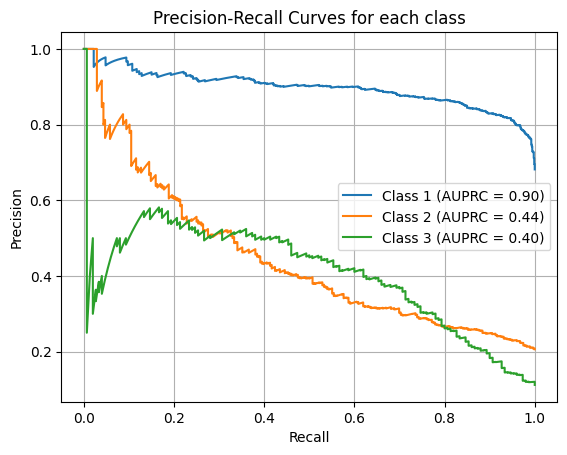


ROC Curves:


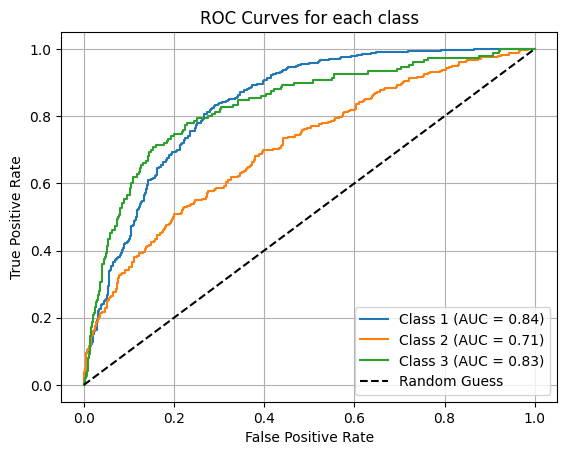


Mean F1 Score: 0.5687
Balanced Accuracy: 0.6099
Average AUPRC: 0.5811

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       912
           1       0.48      0.35      0.41       276
           2       0.36      0.67      0.47       150

    accuracy                           0.70      1338
   macro avg       0.57      0.61      0.57      1338
weighted avg       0.72      0.70      0.70      1338

Fold No: 2
training on folds: [[np.int64(2), np.int64(0), np.int64(3)]]
validation on folds: 1
test on folds: 4
Epoch [1/100], Loss: 1.0803, Accuracy: 0.4059
Validation Loss: 1.1313, Validation Accuracy: 0.3425
Epoch [2/100], Loss: 1.0317, Accuracy: 0.5255
Validation Loss: 0.9903, Validation Accuracy: 0.4579
Epoch [3/100], Loss: 1.0003, Accuracy: 0.5902
Validation Loss: 1.0088, Validation Accuracy: 0.4785
Epoch [4/100], Loss: 0.9760, Accuracy: 0.6157
Validation Loss: 0.9564, Validation Accuracy: 0.4684
Epoch [5/100], L

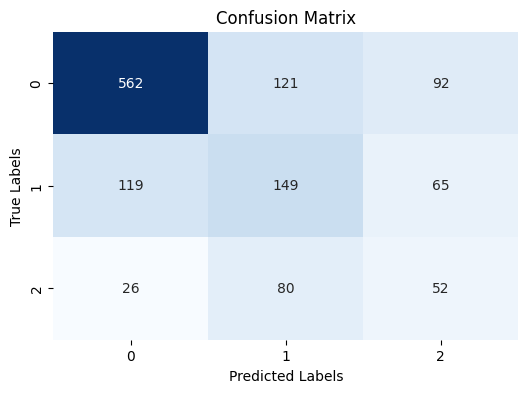


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 562/775 (72.52%)
Class 1: Correct Predictions / Total True Samples = 149/333 (44.74%)
Class 2: Correct Predictions / Total True Samples = 52/158 (32.91%)

Precision-Recall Curves:


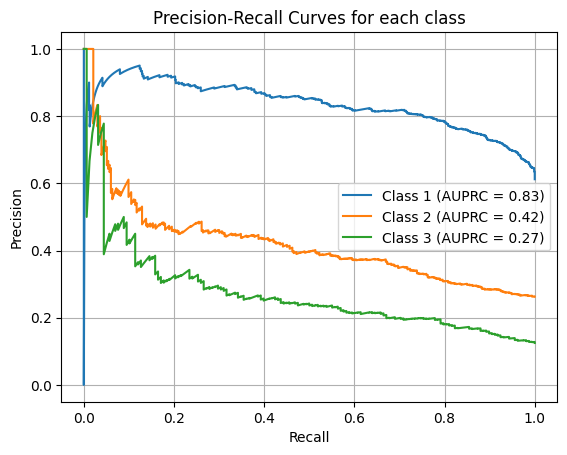


ROC Curves:


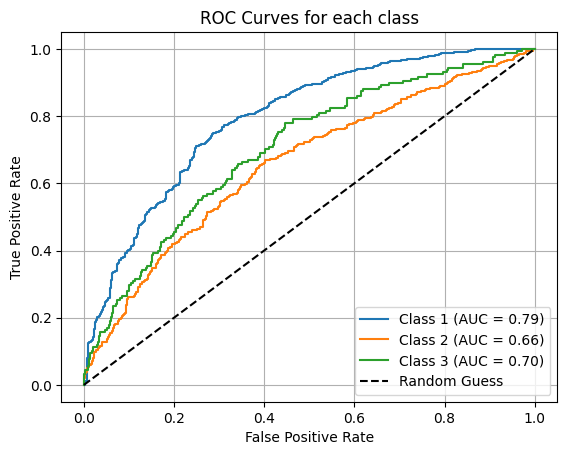


Mean F1 Score: 0.4927
Balanced Accuracy: 0.5006
Average AUPRC: 0.5084

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.73      0.76       775
           1       0.43      0.45      0.44       333
           2       0.25      0.33      0.28       158

    accuracy                           0.60      1266
   macro avg       0.49      0.50      0.49      1266
weighted avg       0.63      0.60      0.61      1266

Fold No: 3
training on folds: [[np.int64(1), np.int64(0), np.int64(3)]]
validation on folds: 4
test on folds: 2
Epoch [1/100], Loss: 1.0915, Accuracy: 0.4070
Validation Loss: 1.0981, Validation Accuracy: 0.4281
Epoch [2/100], Loss: 1.0343, Accuracy: 0.5157
Validation Loss: 1.0598, Validation Accuracy: 0.4641
Epoch [3/100], Loss: 1.0163, Accuracy: 0.5517
Validation Loss: 1.0118, Validation Accuracy: 0.4944
Epoch [4/100], Loss: 0.9930, Accuracy: 0.5885
Validation Loss: 0.9991, Validation Accuracy: 0.5051
Epoch [5/100], L

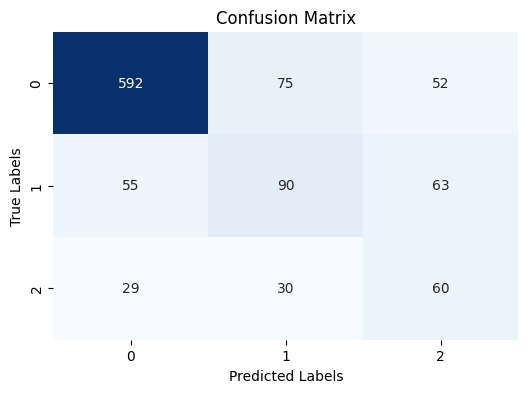


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 592/719 (82.34%)
Class 1: Correct Predictions / Total True Samples = 90/208 (43.27%)
Class 2: Correct Predictions / Total True Samples = 60/119 (50.42%)

Precision-Recall Curves:


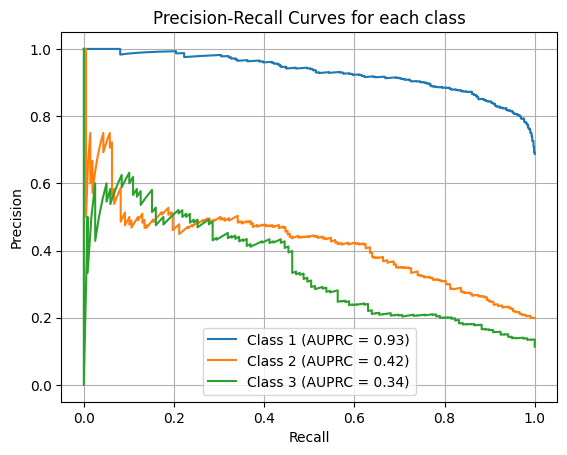


ROC Curves:


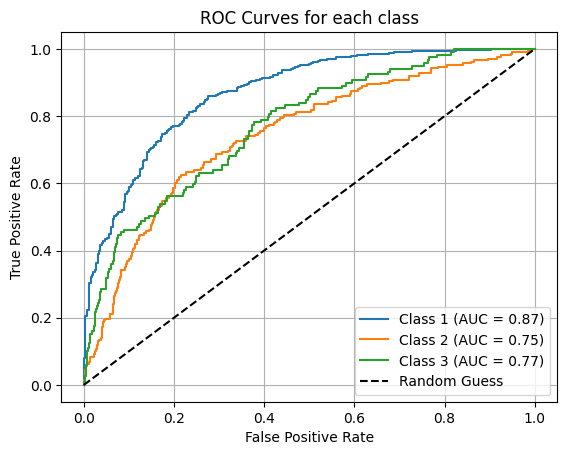


Mean F1 Score: 0.5679
Balanced Accuracy: 0.5868
Average AUPRC: 0.5632

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       719
           1       0.46      0.43      0.45       208
           2       0.34      0.50      0.41       119

    accuracy                           0.71      1046
   macro avg       0.56      0.59      0.57      1046
weighted avg       0.73      0.71      0.72      1046

Fold No: 4
training on folds: [[np.int64(1), np.int64(4), np.int64(3)]]
validation on folds: 2
test on folds: 0
Epoch [1/100], Loss: 1.0888, Accuracy: 0.4130
Validation Loss: 1.0800, Validation Accuracy: 0.4181
Epoch [2/100], Loss: 1.0445, Accuracy: 0.5116
Validation Loss: 1.0501, Validation Accuracy: 0.5065
Epoch [3/100], Loss: 1.0147, Accuracy: 0.5464
Validation Loss: 1.0153, Validation Accuracy: 0.5053
Epoch [4/100], Loss: 0.9985, Accuracy: 0.5942
Validation Loss: 0.9925, Validation Accuracy: 0.5074
Epoch [5/100], L

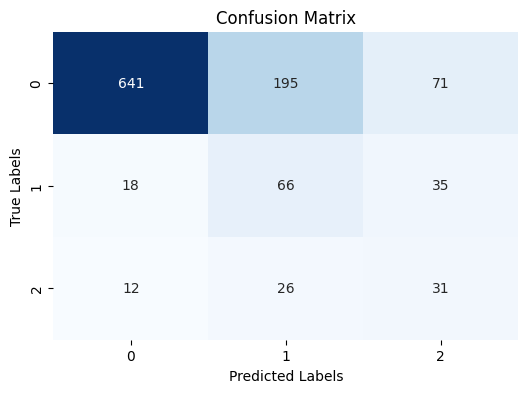


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 641/907 (70.67%)
Class 1: Correct Predictions / Total True Samples = 66/119 (55.46%)
Class 2: Correct Predictions / Total True Samples = 31/69 (44.93%)

Precision-Recall Curves:


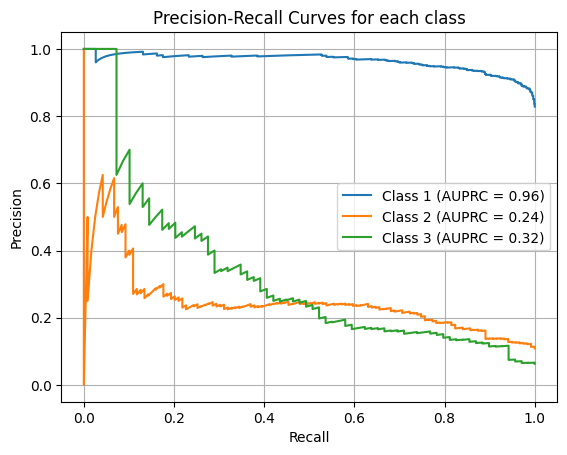


ROC Curves:


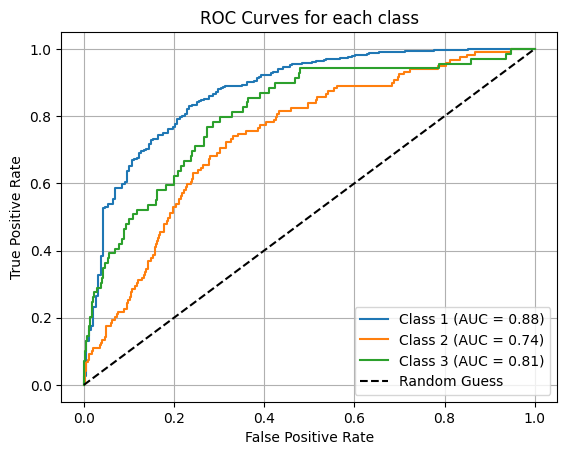


Mean F1 Score: 0.4795
Balanced Accuracy: 0.5702
Average AUPRC: 0.5090

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.71      0.81       907
           1       0.23      0.55      0.33       119
           2       0.23      0.45      0.30        69

    accuracy                           0.67      1095
   macro avg       0.47      0.57      0.48      1095
weighted avg       0.83      0.67      0.73      1095

Fold No: 5
training on folds: [[np.int64(1), np.int64(4), np.int64(2)]]
validation on folds: 0
test on folds: 3
Epoch [1/100], Loss: 1.1002, Accuracy: 0.3778
Validation Loss: 1.0716, Validation Accuracy: 0.4723
Epoch [2/100], Loss: 1.0306, Accuracy: 0.5262
Validation Loss: 1.0555, Validation Accuracy: 0.5056
Epoch [3/100], Loss: 0.9991, Accuracy: 0.5863
Validation Loss: 1.0093, Validation Accuracy: 0.5374
Epoch [4/100], Loss: 0.9782, Accuracy: 0.6120
Validation Loss: 0.9796, Validation Accuracy: 0.5693
Epoch [5/100], L

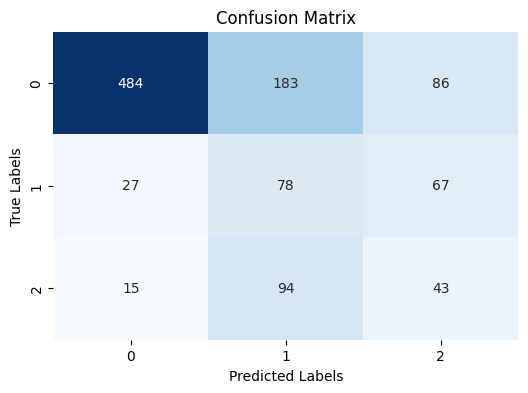


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 484/753 (64.28%)
Class 1: Correct Predictions / Total True Samples = 78/172 (45.35%)
Class 2: Correct Predictions / Total True Samples = 43/152 (28.29%)

Precision-Recall Curves:


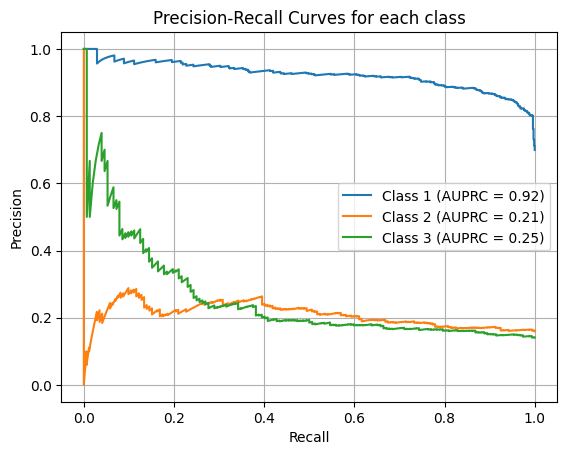


ROC Curves:


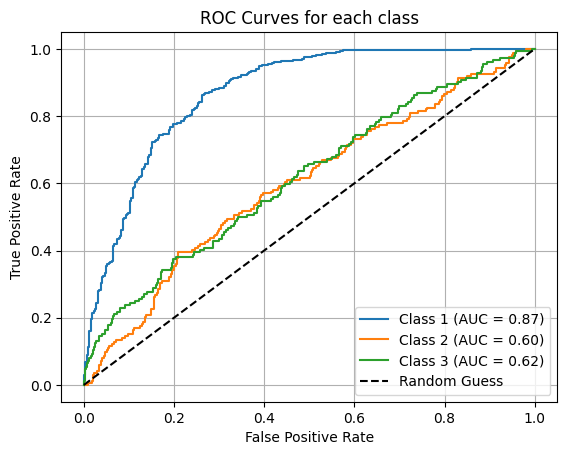


Mean F1 Score: 0.4333
Balanced Accuracy: 0.4597
Average AUPRC: 0.4604

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.64      0.76       753
           1       0.22      0.45      0.30       172
           2       0.22      0.28      0.25       152

    accuracy                           0.56      1077
   macro avg       0.45      0.46      0.43      1077
weighted avg       0.71      0.56      0.61      1077

Accuracy for each fold: [np.float64(0.6098690566997204), np.float64(0.5005742206068869), np.float64(0.5867532580594023), np.float64(0.5702075598786884), np.float64(0.4597151310438919)]
AUPRC for each fold: [np.float64(0.581134801681414), np.float64(0.5083876922946099), np.float64(0.5631745709203575), np.float64(0.508974548528238), np.float64(0.4604306263513873)]
Average AUPRC across all folds: 0.5244204479552013
Average Balanced Accuracy across all folds: 0.545423845257718


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, auc




# Training loop for cross-validation
for fold_idx in range(num_folds):
    print(f'Fold No: {fold_idx + 1}')
    
    # Initialize model, loss, and optimizer
    fold_model = TRANS_CNN(input_shape=input_shape,num_classes=num_classes,embed_dim=128,num_heads=num_heads,num_transformer_blocks=num_transformer_blocks) # Initialize your model here
    fold_model.to(device)
    
    criterion = nn.CrossEntropyLoss(label_smoothing=0.3)
    optimizer = optim.AdamW(fold_model.parameters(), lr=learning_rate,weight_decay=weight_decay)
    
    # Split data into train, validation, and test sets
    test_fold = fold_indices[fold_idx]
    val_fold = val_fold_indices[fold_idx]
    train_folds = [fold for fold in fold_indices if fold != test_fold and fold != val_fold]
    
    print(f"training on folds: {[train_folds]}")
    print(f"validation on folds: {val_fold}")
    print(f"test on folds: {test_fold}")
    

    train_data = np.concatenate([eeg_folds[j] for j in train_folds])
    train_labels = np.concatenate([labels_folds[j] for j in train_folds])
    train_data = train_data.transpose(0, 3, 1, 2)  # Transpose to match PyTorch input format

    test_folds_chosen.append(test_fold)
    val_folds_chosen.append(val_fold)
    
    early_stopping = EarlyStopping(patience=10)
    
    # Training loop
    for epoch in range(epochs):
        balanced_train_data, balanced_train_labels = data_balancer(train_data, train_labels, factor=1)

        train_dataset = TensorDataset(
            torch.tensor(balanced_train_data, dtype=torch.float32).to(device),
            torch.tensor(balanced_train_labels, dtype=torch.long).to(device)
        )
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        fold_model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = fold_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = balanced_accuracy_score(all_labels, all_preds)
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

        # Validation loop
        val_data = eeg_folds[val_fold].transpose(0, 3, 1, 2)
        val_labels = labels_folds[val_fold]
        val_dataset = TensorDataset(
            torch.tensor(val_data, dtype=torch.float32).to(device),
            torch.tensor(val_labels, dtype=torch.long).to(device)
        )
        val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

        fold_model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels_list = []

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_outputs = fold_model(val_inputs)
                loss = criterion(val_outputs, val_labels)
                val_loss += loss.item()

                _, val_batch_preds = torch.max(val_outputs, 1)
                val_preds.extend(val_batch_preds.cpu().numpy())
                val_labels_list.extend(val_labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = balanced_accuracy_score(val_labels_list, val_preds)
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

        early_stopping(val_loss, fold_model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Load the best model
    early_stopping.load_best_model(fold_model)

    # Test loop
    test_data = eeg_folds[test_fold].transpose(0, 3, 1, 2)
    test_labels = labels_folds[test_fold]
    test_dataset = TensorDataset(
        torch.tensor(test_data, dtype=torch.float32).to(device),
        torch.tensor(test_labels, dtype=torch.long).to(device)
    )
    test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

    fold_model.eval()
    test_probs = []
    test_preds = []
    test_labels_list = []

    with torch.no_grad():
        for test_inputs, test_labels in test_loader:
            test_outputs = fold_model(test_inputs)
            probabilities = torch.softmax(test_outputs, dim=1)
            test_probs.extend(probabilities.cpu().numpy())
            _, preds = torch.max(probabilities, 1)
            test_preds.extend(preds.cpu().numpy())
            test_labels_list.extend(test_labels.cpu().numpy())

    # Compute metrics
    test_acc = balanced_accuracy_score(test_labels_list, test_preds)
    fold_accuracies.append(test_acc)

    cm = confusion_matrix(test_labels_list, test_preds)
    fold_confusion_matrices.append(cm)

    test_labels_binarized = label_binarize(test_labels_list, classes=np.arange(num_classes))
    test_auprcs = []
    for class_idx in range(num_classes):
        precision, recall, _ = precision_recall_curve(test_labels_binarized[:, class_idx], np.array(test_probs)[:, class_idx])
        auprc = auc(recall, precision)
        test_auprcs.append(auprc)

    mean_test_auprc = np.mean(test_auprcs)
    fold_auprcs.append(mean_test_auprc)

    print(f'Test Fold {fold_idx + 1}, Mean AUPRC: {mean_test_auprc:.4f}, Balanced Accuracy: {test_acc:.4f}')

    # Use the plot_metrics function to visualize metrics
    plot_metrics(np.array(test_labels_list), np.array(test_probs), n_classes=num_classes)

# Final metrics across all folds
average_auprc = np.mean(fold_auprcs)
mean_accuracy = np.mean(fold_accuracies)
print(f'Accuracy for each fold: {fold_accuracies}')
print(f'AUPRC for each fold: {fold_auprcs}')
print(f'Average AUPRC across all folds: {average_auprc}')
print(f'Average Balanced Accuracy across all folds: {mean_accuracy}')
    


In [14]:
# Save all results to CSV
model_description = f"TRANS_CNN STFT CONCAT MANUAL APPROACH 3 classes"
save_path = r"D:\PYTHONIG\newwindow\NOTEBOOKS_2025\aprilmay2025\newnotebooks\results.csv"
save_results_to_csv(fold_accuracies, fold_auprcs, fold_confusion_matrices, model_description,csv_path=save_path)

Results saved to D:\PYTHONIG\newwindow\NOTEBOOKS_2025\aprilmay2025\newnotebooks\results.csv
